In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from math import sqrt
import numbers

#plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# sklearn
from sklearn.svm import LinearSVC
from sklearn.exceptions import DataConversionWarning; import warnings
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

In [36]:
# load data
data = pd.read_csv('processed_data2.csv') # common words
data = data[data['title'].notna()]
#data = data.reset_index()

In [3]:
# create a column with article categories
data['x_cat'] = data['url'].str.replace('https://ekstrabladet.dk/nyheder/','')
data['x_cat'] = data['x_cat'].str.replace('https://ekstrabladet.dk/','')
data['x_cat'] = data['x_cat'].apply(lambda x: x.split('/')[0])
data = data[~data.x_cat.str.contains('-')]

In [4]:
# remove articles without category
for i, cat in enumerate(data['x_cat']):
    if '-' in cat:
        data['x_cat'][i].drop

In [5]:
# add column with the title lenght
len_title = []
for i in data['title']:
    len_title.append(len(i))
data['len_title'] = pd.DataFrame(data=len_title)

In [6]:
# drop nan
data = data[data['len_title'].notna()]

In [7]:
# blank column
data['set'] = 'hi'

# split the data in 2 
n = len(data['set'])
if n%2 !=0:
    n -= 1
n1 = int(n/2)

# save as traning and test
data['set'][:n1] = 'test'
data['set'][n1:n] = 'train'
df_train = data[data.set=="train"]
df_test = data[data.set=="test"]

C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# models

### OLS

In [25]:
# pipeline for the processed titles and categories
pipeline_ols = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('clf', LinearRegression()),
])

# param grid for the processed titles and categories
param_grid_ols = {"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             #"tfidf__use_idf": [True, False]
            'pol__degree': [1,2,3]
             }

# pipeline for the title lenghts
pipeline_ols_len = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('clf', LinearRegression()),
])

# param grid for the title lenghts
param_grid_ols_len = {#"vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
             #"tfidf__use_idf": [True, False]
            'pol__degree': [1,2,3]
             }


# for storing the results
search_ols_rm = GridSearchCV(pipeline_ols, param_grid_ols, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ols_cat = GridSearchCV(pipeline_ols, param_grid_ols, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ols_len = GridSearchCV(pipeline_ols_len, param_grid_ols_len, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
ols_result = []

In [26]:
# run each data set in the model and store results
#search_ols_rm.fit(df_train.proc_title_rm.values, df_train.comments.values)
#ols_result.append(search_ols_rm)
search_ols_cat.fit(df_train.x_cat.values, df_train.comments.values)
ols_result.append(search_ols_cat)
search_ols_len.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)
ols_result.append(search_ols_len)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1306s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed:    1.3s remaining:    0.0s


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.0s finished


In [33]:
# print the best params and mse
ols_models = ['search_ols_cat', 'search_ols_len']
for i, name in enumerate(ols_models):
    print(f'{name} Best parameter set: {ols_result[i].best_params_}')
    print(f'{name} Best mse: {ols_result[i].best_score_}')

search_ols_cat Best parameter set: {'pol__degree': 3, 'vect__ngram_range': (1, 1)}
search_ols_cat Best mse: -31484.463647899316
search_ols_len Best parameter set: {'pol__degree': 3}
search_ols_len Best mse: -38470.92686977464


### Lasso

In [15]:
# param list
lambdas = np.logspace(-4, 4, 10)

# pipeline for the processed titles and categories
pipeline_las = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('las', Lasso(random_state=1))
])

# param grid used for all 3 data sets
param_grid_las = {'pol__degree': [1,2,3],
    'las__alpha': lambdas}

# pipeline for the title lenghts
pipeline_las_len = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('las', Lasso(random_state=1))
])

# for storing the results
search_las_rm = GridSearchCV(pipeline_las, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_las_cat = GridSearchCV(pipeline_las, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_las_len = GridSearchCV(pipeline_las_len, param_grid_las, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
las_result = []

In [16]:
# run and save results from all the datasets
# search_las_rm.fit(df_train.proc_title_rm.values, df_train.comments.values)
# las_result.append(search_las_rm)
search_las_cat.fit(df_train.x_cat.values, df_train.comments.values)
las_result.append(search_las_cat)
search_las_len.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)
las_result.append(search_las_len)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0359s.) Setting batch_size=4.
[Paral

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0568s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.2s finished


In [34]:
# print best params and mse
las_models = ['search_las_cat', 'search_las_len']
for i, name in enumerate(las_models):
    print(f'{name} Best parameter set: {las_result[i].best_params_}')
    print(f'{name} Best mse: {las_result[i].best_score_}')

search_las_cat Best parameter set: {'las__alpha': 0.046415888336127774, 'pol__degree': 1}
search_las_cat Best mse: -31419.38847973912
search_las_len Best parameter set: {'las__alpha': 166.81005372000558, 'pol__degree': 1}
search_las_len Best mse: -38470.525967167974


### Elastic

In [18]:
ela__l1_ratio = np.linspace(-1, 1, 10)

pipeline_ela = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('ela', ElasticNet())
    #('stanscal', RobustScaler(with_centering=False))
])

param_grid_ela = {'pol__degree': [1,2,3],
                 'ela__l1_ratio': ela__l1_ratio}

pipeline_ela_cat = Pipeline([
    #('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('pol', PolynomialFeatures(include_bias=True)),
    ('ela', ElasticNet())
    #('stanscal', RobustScaler(with_centering=False))
])

search_ela_rm = GridSearchCV(pipeline_ela, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ela_cat = GridSearchCV(pipeline_ela, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)
search_ela_len = GridSearchCV(pipeline_ela_cat, param_grid_ela, scoring='neg_mean_squared_error', cv=3, verbose=10, n_jobs = 4, return_train_score=True)

ela_result = []

In [19]:
# search_ela_rm.fit(df_train.proc_title_rm.values, df_train.comments.values)
# ela_result.append(search_ela_rm)
search_ela_cat.fit(df_train.x_cat.values, df_train.comments.values)
ela_result.append(search_ela_cat)
search_ela_len.fit(df_train.len_title.values.reshape(-1,1), df_train.comments.values)
ela_result.append(search_ela_len)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   22.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0519s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Batch computation too fast (0.1147s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1875s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  73 out of  90 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.6s finished
C:\Users\Jonat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341252039.870243, tolerance: 45155.13252744747
  positive)


In [35]:
# print best params and mse
ela_models = ['search_ela_cat', 'search_ela_len']
for i, name in enumerate(ela_models):
    print(f'{name} Best parameter set: {ela_result[i].best_params_}')
    print(f'{name} Best mse: {ela_result[i].best_score_}')

search_ela_cat Best parameter set: {'ela__l1_ratio': 1.0, 'pol__degree': 3}
search_ela_cat Best mse: -31645.815621138765
search_ela_len Best parameter set: {'ela__l1_ratio': -0.5555555555555556, 'pol__degree': 3}
search_ela_len Best mse: -38470.71018071683


## Validation curves

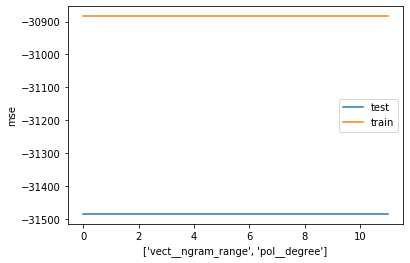

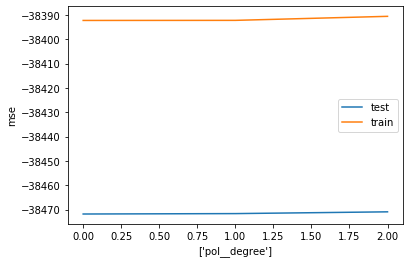

In [28]:
for model in ols_result:
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    x_label = []
    for i in model.param_grid:
        x_label.append(i)
    plt.xlabel(x_label)
    plt.ylabel('mse')
    plt.show()

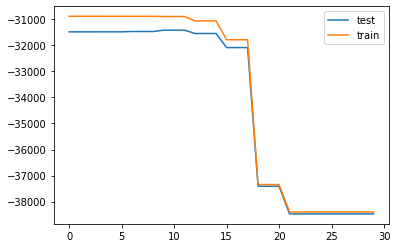

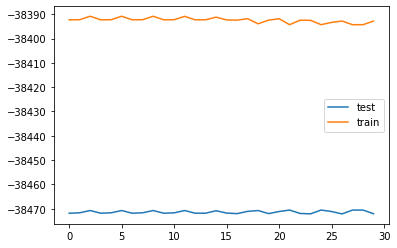

In [23]:
for model in las_result:
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()

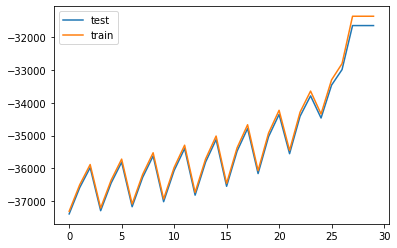

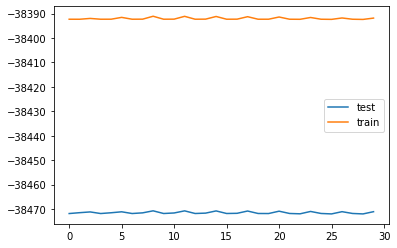

In [24]:
for model in ela_result:
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score'] 
    plt.plot(test_scores, label='test')
    plt.plot(train_scores, label='train')
    plt.legend(loc='best')
    plt.show()